In [1]:
using BenchmarkTools
using Plots

include("../src/Cosmojuly.jl")
import .Cosmojuly as cj

In [6]:
cj.planck18_bkg.Ω_m0
cj.growth_factor(0)

0.7871200975145634

In [ ]:
using Plots

z = 10 .^(range(-2,stop=4,length=100))


Ω_r = MyCosmology.Ω_r.(z)
Ω_m = MyCosmology.Ω_m.(z)
Ω_Λ = MyCosmology.Ω_Λ.(z)

ρ_r = MyCosmology.ρ_r_Msun_Mpc3.(z)
ρ_m = MyCosmology.ρ_m_Msun_Mpc3.(z)
ρ_Λ = MyCosmology.ρ_Λ_Msun_Mpc3.(z)
ρ_c = MyCosmology.ρ_c_Msun_Mpc3.(z)

plot(z, MyCosmology.growth_factor.(z).*(1 .+z), xscale=:log10, color=:blue)
plot!(z, MyCosmology.growth_factor_Carroll.(z).*(1 .+z), xscale=:log10, yscale=:log10, color=:red)

In [5]:
using OrdinaryDiffEq, Interpolations
using SpecialFunctions
using QuadGK
import Unitful: km, s, Gyr, K, Myr, NoUnits, Gauss, A, kg
import UnitfulAstro: Mpc, Gpc, Msun
import PhysicalConstants.CODATA2018: μ_0, c_0, G as G_NEWTON

function numerical_growth_a(ddy, dy, y, p, a)
    Ωm = cj.Ω_vs_a(cj.Matter, a, cj.planck18_bkg)
    Ωm_0 = cj.Ω_vs_a(cj.Matter, 1.0, cj.planck18_bkg)
    Ωr = cj.Ω_vs_a(cj.Radiation, a,cj.planck18_bkg)
    
    ddy .= - (5.0 - 3.0/2.0 * Ωm - 2.0 * Ωr) * dy / a  - (3.0*(1.0-Ωm) - 2.0*Ωr)*y/ a^2 .+ p .* Ωm./Ωm_0 ./ a^3
end

function numerical_growth_lna(ddy, dy, y, p, x)
    Ωm = cj.Ω_vs_a(cj.Matter, exp(x), cj.planck18_bkg)
    Ωm_0 = cj.Ω_vs_a(cj.Matter, 1.0, cj.planck18_bkg)
    Ωr = cj.Ω_vs_a(cj.Radiation, exp(x), cj.planck18_bkg)

    ddy .= - (4.0 - 3.0/2.0 * Ωm - 2.0 * Ωr) * dy  - (3.0*(1.0-Ωm) - 2.0*Ωr)*y .+ p .* Ωm./Ωm_0 .* exp.(.-x)
end

a_init_pmf = cj.z_to_a(1100)
a_init_dens = cj.z_to_a(200)

x_init_pmf = log(a_init_pmf)
x_init_dens = log(a_init_dens)

prob_pmf = SecondOrderODEProblem(numerical_growth_lna, [0.0], [0.0], (x_init_pmf, -0.01), 1.0)
sol_pmf = solve(prob_pmf, Euler(), dt=0.001);

#prob_pmf_a = SecondOrderODEProblem(numerical_growth_a, [0.0], [0.0], (a_init_pmf, 0.99), 1.0)
#sol_pmf_a = solve(prob_pmf_a, Euler(), dt=0.001);

prob_dens = SecondOrderODEProblem(numerical_growth_lna, [0.0], [1.0], (x_init_dens, -0.01), 0.0)
sol_dens = solve(prob_dens, Euler(), dt=0.001);

y_pmf = [sol_pmf.u[i][2] for i in 1:length(sol_pmf.u)]
#y_pmf_a = [sol_pmf_a.u[i][2] for i in 1:length(sol_pmf_a.u)]
y_dens = [sol_dens.u[i][2] for i in 1:length(sol_dens.u)]

z_pmf = cj.a_to_z.(exp.(sol_pmf.t))
#z_pmf_a = cj.a_to_z.(sol_pmf_a.t)
z_dens = cj.a_to_z.(exp.(sol_dens.t))

conv_to_s = 1.0 * (km / Mpc) |> NoUnits

println(conv_to_s)

""" M has to be in units of s^2 """
M   = y_pmf ./ (1 .+ z_pmf ) / (cj.hubble_constant() * conv_to_s)^2 ;
#M_a = y_pmf_a ./ (1 .+ z_pmf_a ) / (cj.hubble_constant()^2);
D   = y_dens ./ (1 .+ z_dens );

log10M = interpolate((log10.(reverse(z_pmf)),), log10.(reverse(M)), Gridded(Linear()))
func_M(z::Real) = z < z_pmf[end] ? M[end] : 10.0^log10M(log10(z))

#log10M_a = interpolate((log10.(reverse(z_pmf_a)),), log10.(reverse(M_a)), Gridded(Linear()))
#func_M_a(z::Real) = z < z_pmf_a[end] ? M_a[end] : 10.0^log10M_a(log10(z))

log10D = interpolate((log10.(reverse(z_dens)),), log10.(reverse(D)), Gridded(Linear()))
func_D(z::Real) = z < z_dens[end] ? D[end] : 10.0^log10D(log10(z))


3.240779289444365e-20


func_D (generic function with 1 method)

In [235]:
function ode_solver_Euler_implicit(p::Function, q::Function, r::Function, xlims::Tuple{<:Real, <:Real}, y0::Real, dy0::Real, dx::Real)
    
    
    wn = Matrix{Float64}(undef, 0, 2)
    xn = Vector{Float64}()

    wn = [wn ; [y0  dy0]]
    append!(xn, xlims[1])

    (xlims[1] > xlims[2]) && (dx = -dx)

    while xn[end] < xlims[2]

        push!(xn, xn[end] + dx)
   
        pn1 = p(xn[end])
        qn1 = q(xn[end])
        rn1 = [0, dx * r(xn[end])]

        inv_M = 1.0/(1.0-dx*pn1-dx^2*qn1) .* [1.0-dx*pn1 dx; dx * qn1 1.0]

        wn = [wn ; (inv_M * (wn[end, :] .+ rn1))']
    
       
    end

    return wn, xn
end

ode_solver_Euler_implicit (generic function with 2 methods)

In [244]:
Ωm(x::Real) = cj.Ω_vs_a(cj.Matter, exp(x), cj.planck18_bkg)
Ωm_0 = cj.Ω_vs_a(cj.Matter, 1.0, cj.planck18_bkg)
Ωr(x::Real) = cj.Ω_vs_a(cj.Radiation, exp(x), cj.planck18_bkg)

func_p(x::Real) = -(4.0 - 3.0/2.0 * Ωm(x) - 2.0 * Ωr(x))
func_q(x::Real) = -(3.0*(1.0 - Ωm(x)) - 2.0*Ωr(x))
func_r(x::Real) = Ωm(x)./Ωm_0 .* exp.(.-x)

res, x = ode_solver_Euler_implicit(func_p, func_q, func_r, (x_init_pmf, -0.01), 0.0, 0.0, 0.001)

z_own = cj.a_to_z.(exp.(x))
M_own = res[:, 1] ./ (1 .+ z_own ) / (cj.hubble_constant() * conv_to_s)^2 ;

plot(z_own, M_own, xscale=:log10)
plot!(z_own, func_M.(z_own), xscale=:log10)

func_M(0.0)

1.9522599648673447e38

In [3]:
println(func_M(0.0)^2)

3.811318970423846e76


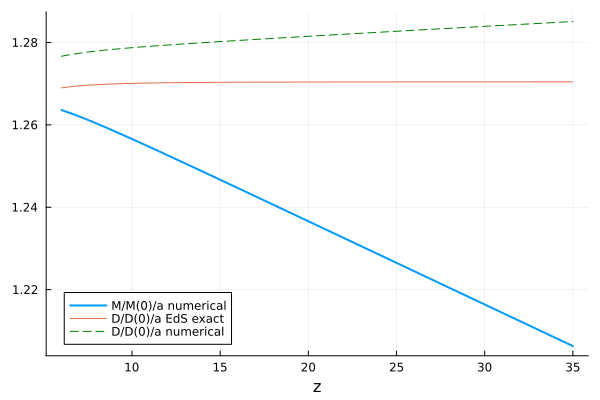

In [33]:
#Plot
z_array = range(6, 35, 50)
plot(z_array, func_M.(z_array)  .* (1.0 .+ z_array) / func_M(0.0), linewidth=2, xaxis = "z", label="M/M(0)/a numerical")
#plot!(z_array, func_M_a.(z_array)  .* (1.0 .+ z_array) / func_M_a(0.0) , linewidth=2, xaxis = "z", label="M/M(0)/a numerical")
plot!(z_array, cj.growth_factor.(z_array)  .* (1.0 .+ z_array) / cj.growth_factor(0.0), label="D/D(0)/a EdS exact")
plot!(z_array, func_D.(z_array) .* (1.0 .+ z_array) / func_D(0.0), linestyle=:dash, color="green", label="D/D(0)/a numerical")


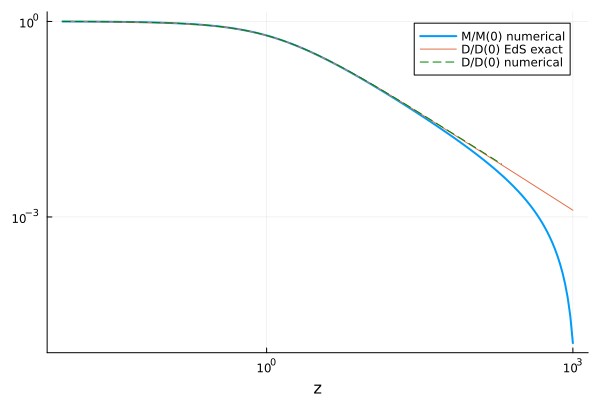

In [34]:
#Plot
z_array_1 = 10.0.^range(-2, 3, 200)
z_array_2 = 10.0.^range(-2, log10(200), 200)
plot(z_array_1, func_M.(z_array_1) ./ func_M(0.0) , linewidth=2, xaxis = "z", xscale=:log10,  yscale=:log10, label="M/M(0) numerical")
plot!(z_array_1, cj.growth_factor.(z_array_1) / cj.growth_factor.(0), label="D/D(0) EdS exact")
plot!(z_array_2, func_D.(z_array_2) ./ func_D(0.0), linestyle=:dash, color="green", label="D/D(0) numerical")

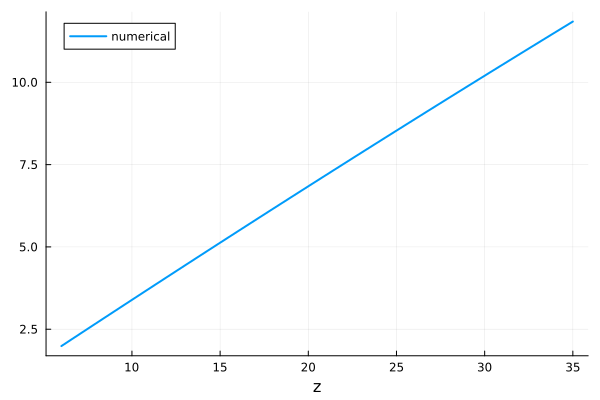

In [24]:
z_array = range(6, 35, 50)
error = 100 .*(1 .- func_M.(z_array).^2 ./ func_M(0.0)^2 ./ (func_D.(z_array).^2 ./ func_D(0.0)^2 ))
plot(z_array,  error, linewidth=2, xaxis = "z", label="numerical")

In [100]:
using SpecialFunctions
using QuadGK
import Unitful: km, s, Gyr, K, Myr, NoUnits, Gauss, A, kg
import UnitfulAstro: Mpc, Gpc, Msun
import PhysicalConstants.CODATA2018: μ_0, c_0, G as G_NEWTON

""" σB0 in nG result in Mpc^{-1}"""
function kA_approx(σB0::Real, nB::Real)
    return (σB0^2 / (2*π)^(3.0+nB) / 4.2e+5  )^(-1.0/(5.0+nB))
end

""" result in Mpc """
function λB(λ::Real, σB0::Real, nB::Real)
    res = 16.0 * π / 25.0 * (σB0 * 1e-9 * 1e-4 * kg / A / s^2)^2/(μ_0 * G_NEWTON * cj.ρ_Msun_Mpc3(cj.Matter) * cj.ρ_Msun_Mpc3(cj.Baryons) * Msun^2 / Mpc^6) * λ^(3+nB) / Mpc^2 |> NoUnits
    return res^(1.0/(5+nB))
end

println((1e-9 * 1e-4 * kg / A / s^2)^2/(μ_0 * G_NEWTON  * Msun^2 / Mpc^6) / Mpc^2 |> NoUnits)

""" σB0 in nG, result in Mpc^{-1} """
kB(σB0::Real, nB::Real) = 2*π/λB(1, σB0, nB)

""" result in units of σB0^2 * Mpc^(3 + nB)"""
amplitude_B0(σB0::Real, nB::Real) = σB0^2 * (2*π)^2 / gamma((nB+3.0)/2.0)

""" result dimensionless: this is the power spectrum devided by kA^nB, x = k/kA """
pmf_power_spectrum(x::Real, nB::Real) = x^nB * exp(-2*x^2)

""" we perform the integral by factoring out the factors kA"""
function _to_integrate_2(x1::Real, μ::Real, x::Real, nB::Real)
    return pmf_power_spectrum(sqrt(x^2 + x1^2 - 2*x*x1*μ), nB) * (x^2 + (x^2-2*x*x1*μ)*μ^2)
end


#function _to_integrate_1(x1::Real, x::Real, nB::Real)
#   
#    gamma_array = [gamma(p+nB/2.0, 2.0*(x-x1)^2) - gamma(p+nB/2.0, 2.0*(x+x1)^2) for p in 1:4]
#   
#    c1 = -8.0*x^2*(-3.0*x^4 + 2.0*x^2*x1^2 + x1^4)
#    c2 = 4.0 * (x^4 + 4.0*x^2*x1^2 + 3.0*x1^4)
#    c3 = -2.0*(2.0*x^2+3.0*x1^2)
#    c4 = 1.0
#    
#    c_array = [c1, c2, c3, c4]
#    
#    return pmf_power_spectrum(x1, nB) * sum(c_array .* gamma_array) / x^5 / x1 / 2^(7+nB/2.0)
#end


function _to_integrate_1(x1::Real, x::Real, nB::Real)
    return  x1^2 * pmf_power_spectrum(x1, nB) * quadgk(μ -> _to_integrate_2(x1, μ, x, nB), -1.0, 1.0, rtol=1e-3)[1]
end


function power_spectrum_v(k::Real, σB0::Real, nB::Real)

    kA = kA_approx(σB0, nB)
    amp = amplitude_B0(σB0, nB)

    return (k/(4*π))^2  * amp^2 * kA^(5+2*nB) * quadgk(lnx1 -> _to_integrate_1(exp(lnx1), k / kA, nB)*exp(lnx1), -3 - log(kA), 3, rtol=1e-3)[1]
    
end


function power_Lorentz(σB0::Real, nB::Real)
    kA = kA_approx(σB0, nB)
    amp = amplitude_B0(σB0, nB)
    return quadgk(lnk -> power_spectrum_v(exp(lnk), σB0, nB)*exp(lnk), log(1e-6), log(1e+8), rtol=1e-3)[1] / (2*π^2) / kA^2 / amp^2
end


""" σB0 in nG, result in Mpc^3 """
function matter_pmf_spectrum(k::Real, σB0::Real, nB::Real, growth_M::Union{Function, Real} = 1.9522599648673447e38, z::Real = 0.0)
    
    kA = kA_approx(σB0, nB)
    x = k / kA
    amp = amplitude_B0(σB0, nB)

    #res = amp^2 * kA^(5+2*nB) * quadgk(lnx1 -> _to_integrate_1(exp(lnx1), x, nB)*exp(lnx1), -3 - log(kA), 3, rtol=1e-3)[1]
    
    fb = cj.Ω(cj.Baryons, 0.0) / cj.Ω(cj.Matter, 0.0)
    ρb_0 = cj.ρ_Msun_Mpc3(cj.Baryons, 0.0) * Msun / Mpc^3

    #Π = ( (fb * (k / Mpc ))^2 / ( 4*π * μ_0 * ρb_0)^2 * res * (1e-9 * 1e-4 * kg / A / s^2)^4 * Mpc )/ (s^(-4) * Mpc^3) |> NoUnits

    Π = (fb /(μ_0 * ρb_0))^2 * power_spectrum_v(k, σB0, nB) * ( (1 / Mpc )^2 * (1e-9 * 1e-4 * kg / A / s^2)^4 * Mpc )/ (s^(-4) * Mpc^3)|> NoUnits
    growth = NaN

    isa(growth_M, Function) && (growth = growth_M(z))
    (typeof(growth_M) <:Real) && (growth = growth_M)

    return growth^2 * Π / (1.0  + (k / kB(σB0, nB))^2)^2

end


Π = ( (1 / Mpc )^2 / ( 4*π * μ_0 *  Msun / Mpc^3 )^2 * (1e-9 * 1e-4 * kg / A / s^2)^4 * Mpc )/ (s^(-4) * Mpc^3) |> NoUnits

2.7338505671410205e19


9.657168589894663e-59

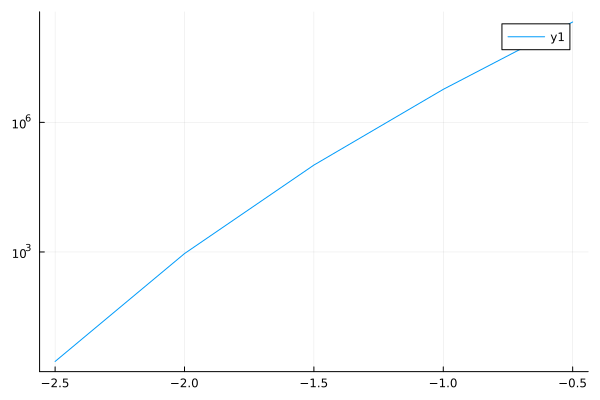

In [102]:
nB_array = [-2.5, -2.0, -1.5, -1.0, -0.5]# 0.0]
plot(nB_array, power_Lorentz.(0.01, nB_array), yscale=:log10)

#k_array = 10.0.^range(-3, 4, 50)
#plot(k_array, power_spectrum_v.(k_array, 0.1, -2.5), yscale=:log10, xscale=:log10)

In [128]:
function σ_with_pmf(M::Union{Real, Vector{<:Real}, StepRangeLen{<:Real}}, z::Real, σB0::Real, nB::Real)
    k_max = 1.1/cj.radius_from_mass(minimum(M), cj.SharpK)
    log10k_array = range(log10(exp(-8)), log10(k_max), 1000)
    log10_matter_pmf_spectrum = interpolate((log10k_array, ), log10.(matter_pmf_spectrum.(10.0.^log10k_array, σB0, nB, func_M, z)), Gridded(Linear()))
    matter_pmf_spectrum_interp(k::Real) = 10.0.^log10_matter_pmf_spectrum(log10(k))
    println(matter_pmf_spectrum_interp.(10.0.^log10k_array)[end-4:end], " ", cj.matter_power_spectrum.(10.0.^log10k_array, z, dimensionless=true)[end-4:end])
    total_spectrum(k::Real) = k^3 / (2*π^2) * matter_pmf_spectrum_interp(k)  + cj.matter_power_spectrum(k, z, dimensionless=true)
    println(total_spectrum.(10.0.^log10k_array)[end-4:end])
    return sqrt.(cj.σ²_vs_M.(M, cj.SharpK, k->( k^3 / (2*π^2) * matter_pmf_spectrum_interp(k)  + cj.matter_power_spectrum(k, z, dimensionless=true))))
end

function σ2_with_pmf(R_array::Union{Real, Vector{<:Real}, StepRangeLen{<:Real}, Matrix{<:Real}}, z::Real, σB0::Real, nB::Real)
    k_max = 1.1/minimum(R_array)
    log10k_array = range(log10(exp(-8)), log10(k_max), 1000)
    log10_matter_pmf_spectrum = interpolate((log10k_array, ), log10.(matter_pmf_spectrum.(10.0.^log10k_array, σB0, nB, func_M, z)), Gridded(Linear()))
    matter_pmf_spectrum_interp(k::Real) = 10.0.^log10_matter_pmf_spectrum(log10(k))
    return cj.σ².(R_array, cj.SharpK, k->( k^3 / (2*π^2) * matter_pmf_spectrum_interp(k)  + cj.matter_power_spectrum(k, z, dimensionless=true)))
end

function dσ2_with_pmf(R_array::Union{Real, Vector{<:Real}, StepRangeLen{<:Real}, Matrix{<:Real}}, z::Real, σB0::Real, nB::Real)
    k_max = 1.1/minimum(R_array)
    log10k_array = range(log10(exp(-8)), log10(k_max), 1000)
    log10_matter_pmf_spectrum = interpolate((log10k_array, ), log10.(matter_pmf_spectrum.(10.0.^log10k_array, σB0, nB, func_M, z)), Gridded(Linear()))
    matter_pmf_spectrum_interp(k::Real) = 10.0.^log10_matter_pmf_spectrum(log10(k))
    return cj.dσ²_dR.(R_array, cj.SharpK, k->( k^3 / (2*π^2) * matter_pmf_spectrum_interp(k)  + cj.matter_power_spectrum(k, z, dimensionless=true)))
end

function dσ2_M_with_pmf(M_array::Union{Real, Vector{<:Real}, StepRangeLen{<:Real}, Matrix{<:Real}}, z::Real, σB0::Real, nB::Real)
    k_max = 1.1/cj.radius_from_mass(minimum(M_array), cj.SharpK)
    log10k_array = range(log10(exp(-8)), log10(k_max), 1000)
    log10_matter_pmf_spectrum = interpolate((log10k_array, ), log10.(matter_pmf_spectrum.(10.0.^log10k_array, σB0, nB, func_M, z)), Gridded(Linear()))
    matter_pmf_spectrum_interp(k::Real) = 10.0.^log10_matter_pmf_spectrum(log10(k))
    return cj.dσ²_dM.(M_array, cj.SharpK, k->( k^3 / (2*π^2) * matter_pmf_spectrum_interp(k)  + cj.matter_power_spectrum(k, z, dimensionless=true)))
end

function dn_dM_with_pmf(M::Union{Real, Vector{<:Real}, StepRangeLen{<:Real}}, z::Real, σB0::Real, nB::Real)
    k_max = 1.1/cj.radius_from_mass(minimum(M), cj.SharpK)
    log10k_array = range(log10(exp(-8)), log10(k_max), 1000)
    log10_matter_pmf_spectrum = interpolate((log10k_array, ), log10.(matter_pmf_spectrum.(10.0.^log10k_array, σB0, nB, func_M, 0.0)), Gridded(Linear()))
    matter_pmf_spectrum_interp(k::Real) = 10.0.^log10_matter_pmf_spectrum(log10(k))
    return  cj.dn_dM.(M, z, k->( k^3 / (2*π^2) * matter_pmf_spectrum_interp(k)  + cj.matter_power_spectrum(k, 0.0, dimensionless=true)), cj.SharpK)
end


dn_dM_with_pmf (generic function with 1 method)

In [125]:
k_max = 1.1/cj.radius_from_mass(minimum(1e+2), cj.SharpK)
log10k_array = range(log10(exp(-8)), log10(k_max), 1000)

σ_with_pmf(1e+2, 0.0, 0.1, -2.5)
#println(cj.matter_power_spectrum.(10.0.^log10k_array, 0.0, dimensionless=true)[end-4:end])

[1.5959609444342685e-6, 1.32261450172886e-6, 1.0919072325375083e-6, 8.982176178902351e-7, 7.361254313956753e-7] [51.54062972648599, 51.6662729925745, 51.79198999603119, 51.91778048309022, 52.04364420032211]
[51.54062972648599, 51.6662729925745, 51.79198999603119, 51.91778048309022, 52.04364420032211]


14.228208668150076

In [28]:
sigma = Matrix{Float64}(undef, 50, 60 )
M_array = 10.0.^range(4, 10, 60)
z_array = range(6, 50, 50)

sigma_0 = σ_with_pmf(M_array, 0.0, 0.1, -2.5)

for i in 1:50
    sigma[i, :] .= sigma_0 ./ σ_with_pmf(M_array, z_array[i], 0.1, -2.5) * cj.growth_factor_Carroll(z_array[i]) / cj.growth_factor_Carroll(0.0)
end

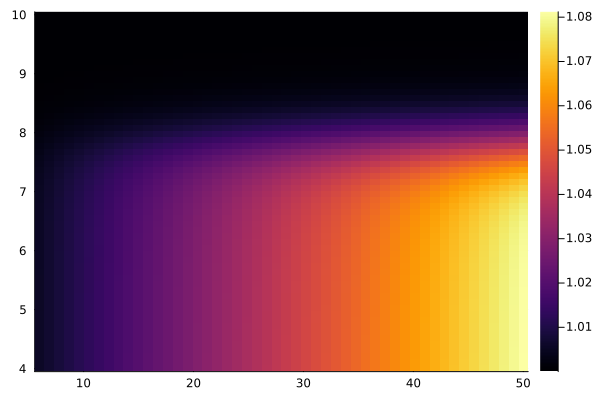

In [29]:
heatmap(z_array, log10.(M_array), sigma')

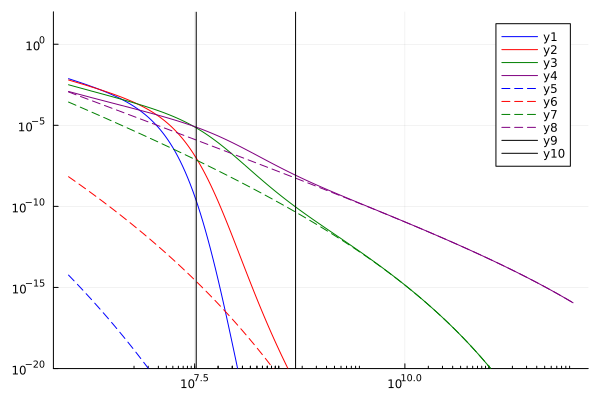

In [129]:
M_array = 10.0.^range(6, 12, 200)
plot(M_array, dn_dM_with_pmf(M_array, 50.0, 0.1, -2.5), xscale=:log10, yscale=:log10, color=:blue)
plot!(M_array, dn_dM_with_pmf(M_array, 35.0, 0.1, -2.5), xscale=:log10, yscale=:log10, color=:red)
plot!(M_array, dn_dM_with_pmf(M_array, 15.0, 0.1, -2.5), xscale=:log10, yscale=:log10, color=:green)
plot!(M_array, dn_dM_with_pmf(M_array, 5.0, 0.1, -2.5), xscale=:log10, yscale=:log10, color=:purple)
plot!(M_array, cj.dn_dM.(M_array, 50.0, cj.SharpK), linestyle=:dash, color=:blue)
plot!(M_array, cj.dn_dM.(M_array, 35.0, cj.SharpK), linestyle=:dash, color=:red)
plot!(M_array, cj.dn_dM.(M_array, 15.0, cj.SharpK), linestyle=:dash, color=:green)
plot!(M_array, cj.dn_dM.(M_array, 5.0, cj.SharpK), linestyle=:dash, color=:purple)
plot!([10^(8.7), 10^(8.7)], [1e-100, 1e+2], color=:black)
plot!([3.3e+7, 3.3e+7], [1e-100, 1e+2], color=:black)
plot!(xminorticks=10, ylim=[1e-20, 1e+2])

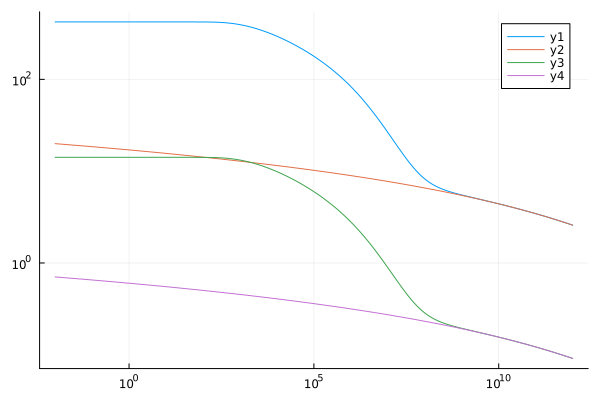

In [87]:
M_array = 10.0.^range(-2, 12, 200)

plot(M_array, σ_with_pmf(M_array, 0.0, 0.1, -2.5), xscale=:log10)
plot!(M_array, cj.σ_vs_M.(M_array, cj.SharpK), xscale=:log10, yscale=:log10)
plot!(M_array, σ_with_pmf(M_array, 35, 0.1, -2.5)) 
plot!(M_array, cj.σ_vs_M.(M_array, cj.SharpK) * cj.growth_factor_Carroll(35.0) / cj.growth_factor_Carroll(0), xscale=:log10, yscale=:log10)

In [94]:
kh_array = 10.0.^range(-4, 4, 100)
σB0_array = 0.02:0.02:0.2
nB_array  = -2.9:0.1:-2.0
res_1 = [matter_pmf_spectrum.(kh_array * cj.planck18_bkg.h, s, -2.5, func_M) * (cj.planck18_bkg.h)^3 for  s in σB0_array];
#res_1_tot = [total_spectrum.(kh_array * cj.planck18_bkg.h, s, -2.5, func_M) * (cj.planck18_bkg.h)^3 for  s in σB0_array];
res_2 = [matter_pmf_spectrum.(kh_array * cj.planck18_bkg.h, 0.1, n, func_M) * (cj.planck18_bkg.h)^3 for  n in nB_array];

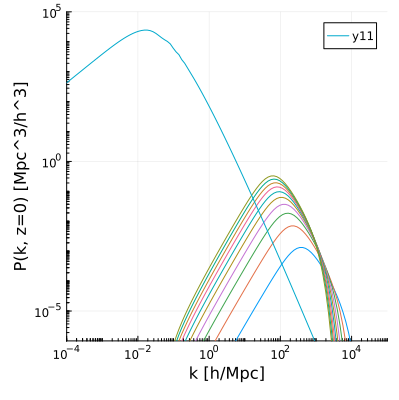

In [95]:
p = plot(minorticks=10, size=(400,400), xticks = [1e-4, 1e-2, 1e-0, 1e+2, 1e+4])
plot!(p, ylim=[1e-6, 1e+5], xlim=[1e-4, 1e+5], xlabel="k [h/Mpc]", ylabel="P(k, z=0) [Mpc^3/h^3]")
plot!(p, kh_array, res_1, xscale=:log10, yscale=:log10, label="")
#plot!(p, kh_array, res_1_tot, xscale=:log10, yscale=:log10, label="", linestyle=:dash)
plot!(p, kh_array, cj.matter_power_spectrum.(kh_array * cj.planck18_bkg.h)* (cj.planck18_bkg.h)^3)

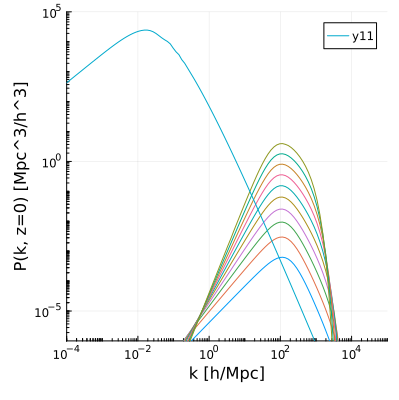

In [49]:
p = plot(minorticks=10, size=(400,400), xticks = [1e-4, 1e-2, 1e-0, 1e+2, 1e+4])
plot!(p, ylim=[1e-6, 1e+5], xlim=[1e-4, 1e+5], xlabel="k [h/Mpc]", ylabel="P(k, z=0) [Mpc^3/h^3]")
plot!(p, kh_array, res_2, xscale=:log10, yscale=:log10, label="")
plot!(p, kh_array, cj.matter_power_spectrum.(kh_array * cj.planck18_bkg.h)* (cj.planck18_bkg.h)^3)

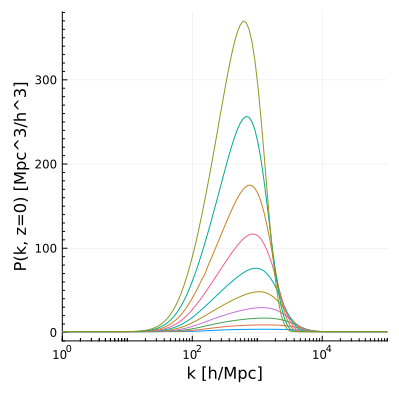

In [160]:
kh_array = 10.0.^range(-4, 5, 200)
σB0_array = 0.02:0.02:0.2
nB_array  = -2.9:0.1:-2.0
res_1 = [matter_pmf_spectrum.(kh_array * cj.planck18_bkg.h, s, -2.5) * (cj.planck18_bkg.h)^3 for  s in σB0_array];
res_2 = [matter_pmf_spectrum.(kh_array * cj.planck18_bkg.h, 0.1, n) * (cj.planck18_bkg.h)^3 for  n in nB_array];

p = plot(minorticks=10, size=(400,400), xticks = [1e-4, 1e-2, 1e-0, 1e+2, 1e+4])
ΛCDM_PS = cj.matter_power_spectrum.(kh_array * cj.planck18_bkg.h)* (cj.planck18_bkg.h)^3
tf_1 = [sqrt.((ΛCDM_PS .+ r) ./ ΛCDM_PS) for r in res_1]
tf_2 = [sqrt.((ΛCDM_PS .+ r) ./ ΛCDM_PS) for r in res_2]
plot!(p, xlim=[1e-0, 1e+5], xlabel="k [h/Mpc]", ylabel="P(k, z=0) [Mpc^3/h^3]")
plot!(p, kh_array, tf_2, xscale=:log10, label="")

In [59]:
(M[end] / (km / Mpc)^2 |> NoUnits)

1.8588260010348062e77

In [41]:
R_min = cj.radius_from_mass(1e-2)
R_max = cj.radius_from_mass(1e+12)
log10_R_array = cj.range(log10(R_min),log10(R_max), 400)
log10_σ2_pmf = interpolate((log10_R_array,), log10.(σ2_with_pmf.(10.0.^log10_R_array, 0, 1.0, -2.5)), Gridded(Linear()))

400-element interpolate((-4.406274830080027:0.011695906432748537:0.2603918365866398,), ::Vector{Float64}, Gridded(Linear())) with element type Float64:
 5.245206085242073
 5.245196800979756
 5.245179638699458
 5.245174496729201
 5.2451568553200465
 5.245178672871133
 5.245175225336266
 5.2451357945120485
 5.245114273190483
 5.245048001782958
 ⋮
 0.5677440749260682
 0.5564693634469218
 0.54512117516126
 0.5336981836359604
 0.522199614403898
 0.5106240815061591
 0.4989707488758609
 0.48723873686443303
 0.47542648612404304

In [6]:
using Roots

function R_vs_S(S::Real)
    R_min = cj.radius_from_mass(1e-2)
    R_max = cj.radius_from_mass(1e+12)
    return 10.0.^find_zero(log10r->(log10_σ2_pmf(log10r) - log10(S)), (log10(R_min), log10(R_max)), Bisection(), xrtol=1e-7)
end

R_vs_S (generic function with 1 method)

In [42]:
R_vs_S(σ2_with_pmf(0.02, 0, 1.0, -2.5))
#cj.radius_from_mass(1e-2)
#cj.radius_from_mass(1e+12)
#σ2_with_pmf(0.01, 0, 0.1, -2.5)

0.01999891637931696

In [44]:
S_max = 0.99*σ2_with_pmf(R_min, 0, 1.0, -2.5)
S_min = 1.01*σ2_with_pmf(R_max, 0, 1.0, -2.5)

S_range = 10.0.^range(log10(S_min), log10(S_max), 200);

In [ ]:
σ2_0 = σ2_with_pmf(R_vs_S.(S_range), 0, 0.1, -2.5)
σ2_10 = σ2_with_pmf(R_vs_S.(S_range), 10, 0.1, -2.5)
σ2_20 = σ2_with_pmf(R_vs_S.(S_range), 20, 0.1, -2.5)
σ2_30 = σ2_with_pmf(R_vs_S.(S_range), 30, 0.1, -2.5)
σ2_40 = σ2_with_pmf(R_vs_S.(S_range), 40, 0.1, -2.5)

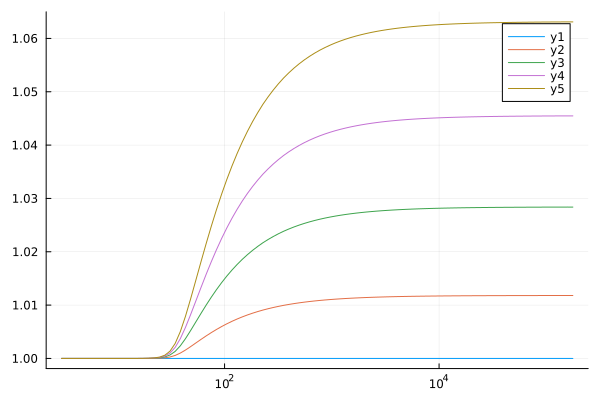

In [8]:
plot(S_range, sqrt.(σ2_0./σ2_0) .* ( cj.growth_factor_Carroll(0.0) / cj.growth_factor_Carroll(0.0)), xscale=:log10)
plot!(S_range, sqrt.(σ2_0./σ2_10)  .* ( cj.growth_factor_Carroll(10.0) / cj.growth_factor_Carroll(0)), xscale=:log10)
plot!(S_range, sqrt.(σ2_0./σ2_20)  .* ( cj.growth_factor_Carroll(20.0) / cj.growth_factor_Carroll(0)), xscale=:log10)
plot!(S_range, sqrt.(σ2_0./σ2_30)  .* ( cj.growth_factor_Carroll(30.0) / cj.growth_factor_Carroll(0)), xscale=:log10)
plot!(S_range, sqrt.(σ2_0./σ2_40)  .* ( cj.growth_factor_Carroll(40.0) / cj.growth_factor_Carroll(0)), xscale=:log10)

We see above that the barrier increases on large $S$ (small $R$) at large redshift due to a lower pmf-induced matter power spectrum at large and large redshift in comparison to the classical barrier where the entire power spectrum evolves with the same growth function

We want to solve the equation
\begin{equation}
P_{\rm FPT}(S) = \frac{w(z, S)}{S} \left\{\left[1 - \frac{\partial \ln w(z, S)}{\partial \ln S}\right]P_{\rm free}[w(z, S), S] + \int_0^S {\rm d} s \left[ \frac{\partial \ln w(z, S)}{\partial \ln S}   - \frac{1 - w(z, s)/w(z, S)}{1-s/S} \right]P_{\rm free}[w(z, S) - w(z, s), S-s] F_{\rm FPT}(s)\right\}
\end{equation}
In order to solve this equation on several orders of magnitudes we can introduce $\omega(z, X) = w\left(z, e^X\right)$ and solve for $\tilde P_{\rm FPT}(X) = P_{\rm FPT}(e^X)$

Then,
\begin{equation}
\tilde P_{\rm FPT}(X) = \omega(z, X)e^{-X} \left\{\left[1- \frac{\partial \ln \omega(s, X)}{\partial X}\right]\tilde P_{\rm free}[\omega(z, X), X] + \int_{-\infty}^{X} {\rm d} x e^x \left[\frac{\partial \ln \omega(s, X)}{\partial X} - \frac{1-\omega(z, x)/\omega(z, X)}{1-e^{x-X}}\right]\tilde P_{\rm free}[\omega(z, X) - \omega(z, x), X-x] \tilde F_{FPT}(x)  \right\}
\end{equation}

Here we have
\begin{equation}
w(z, S) = \delta_{\rm c} \frac{\sqrt{S}}{\sigma(z, R(S))}
\end{equation}
and we introduce $\Sigma(z, X) = \sigma(z, R(e^X))$ therefore
\begin{equation}
\omega(z, X) = \delta_{\rm c} \frac{e^{X/2}}{\Sigma(z, X)}
\end{equation}
In the end
\begin{equation}
\frac{\partial \ln \omega(s, X)}{\partial X} = 1 - \frac{\partial \ln \Sigma^2(z, X)}{\partial X}
\end{equation}

In [48]:
dlnw_dlnS = 1 .- (dσ2_with_pmf(R_vs_S.(S_range), 30, 1, -2.5) ./ dσ2_with_pmf(R_vs_S.(S_range), 0, 1, -2.5)) ./ σ2_with_pmf(R_vs_S.(S_range), 30, 1, -2.5) .* S_range

200-element Vector{Float64}:
  9.25378191428683e-5
  0.00011239085538361504
  0.0001381306324651499
  0.0001707306023956967
  0.00021131349047520676
  0.0002618609933714433
  0.00032769757859019144
  0.00043846212593867673
  0.0005744189660035204
  0.0007434998014484995
  ⋮
  0.0005578577824875142
  0.00040313922396773005
  0.00028512044999640107
  0.00046916381657136075
  0.00015120264281454077
  5.4952283193743234e-5
  0.00019015318353454713
  0.00013491609968752094
 -0.00011458571964162445

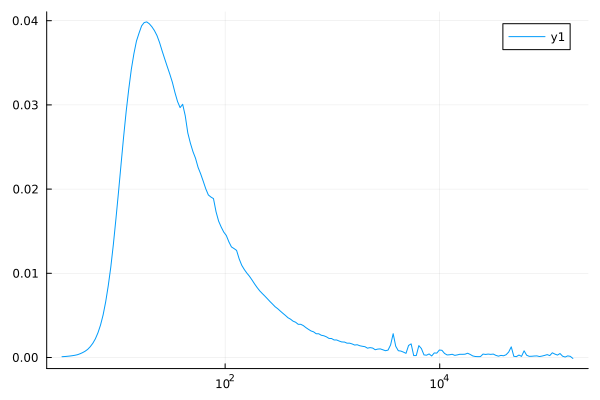

In [49]:
plot(S_range, dlnw_dlnS, xscale=:log10)
#plot(S_range, dσ2_with_pmf(R_vs_S.(S_range), 20, 0.1, -2.5), xscale=:log10)
#plot!(S_range, σ2_with_pmf(R_vs_S.(S_range), 0, 0.1, -2.5), xscale=:log10)
#plot(S_range, σ2_with_pmf(R_vs_S.(S_range), 20, 0.1, -2.5))

In [50]:
function p_free(δ::Real, S::Real)
    (S <= 0) && (return 0.0)
    return 1.0/sqrt(2.0*π*S) *exp(-δ^2/(2*S))
end

p_free (generic function with 1 method)

In [52]:
using LinearAlgebra

s_range = transpose(S_range)

wS = 1.686 * sqrt.(σ2_with_pmf(R_vs_S.(S_range), 0, 1, -2.5) ./ σ2_with_pmf(R_vs_S.(S_range), 30, 1, -2.5))
ws = transpose(wS)

matrix_M = wS ./ S_range .* s_range .* ( dlnw_dlnS  .- (1.0 .- ws./wS) ./ (1.0 .- s_range ./ S_range)) .* p_free.(wS .- ws, S_range .- s_range )  
vector_X = wS ./ S_range .* (1.0 .- dlnw_dlnS) .* p_free.(wS, S_range) 

for i in 1:size(matrix_M)[1]
    matrix_M[i, i] = 0
end

matrix_M = LowerTriangular(matrix_M)
#vector_X

200×200 LowerTriangular{Float64, Matrix{Float64}}:
  0.0           ⋅            ⋅          …    ⋅            ⋅           ⋅ 
  0.00266737   0.0           ⋅               ⋅            ⋅           ⋅ 
  0.00222204   0.00311128   0.0              ⋅            ⋅           ⋅ 
  0.00214495   0.00261744   0.00365053       ⋅            ⋅           ⋅ 
  0.00218953   0.00253214   0.00307876       ⋅            ⋅           ⋅ 
  0.00230268   0.00258982   0.0029856   …    ⋅            ⋅           ⋅ 
  0.00249697   0.00276307   0.00310048       ⋅            ⋅           ⋅ 
  0.00300108   0.00329422   0.00364899       ⋅            ⋅           ⋅ 
  0.00351778   0.0038373    0.00421202       ⋅            ⋅           ⋅ 
  0.00407307   0.0044214    0.00482092       ⋅            ⋅           ⋅ 
  ⋮                                     ⋱                            
 -5.92318e-8  -6.25835e-8  -6.61239e-8       ⋅            ⋅           ⋅ 
 -5.47316e-8  -5.78287e-8  -6.11001e-8       ⋅            ⋅           ⋅ 
 -5

In [53]:
p_FPT = inv(I - matrix_M) * vector_X

200-element Vector{Float64}:
 9.499622113613265e-122
 2.8482981594037836e-115
 3.821836123978632e-109
 2.3958372983062056e-103
 7.308400327480431e-98
 1.1274402666096206e-92
 9.121967367333363e-88
 4.006371188879667e-83
 9.868010436605159e-79
 1.405666648926484e-74
 ⋮
 4.5184256164194867e-7
 4.1510616372645375e-7
 3.8158178572245676e-7
 3.525604054581926e-7
 3.2297264397129204e-7
 2.969774244578928e-7
 2.7415126892649374e-7
 2.522557092220484e-7
 2.3134337347931015e-7

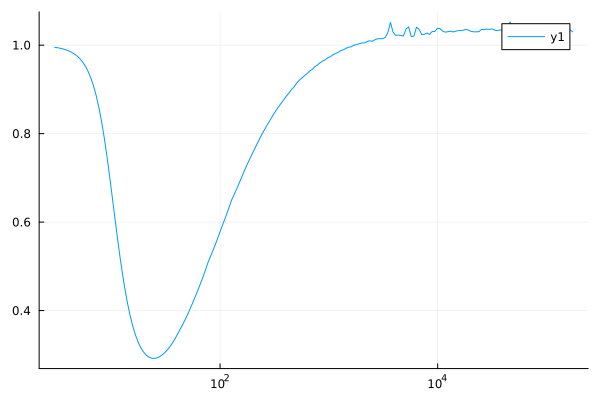

In [54]:
wS_free = 1.686 * cj.growth_factor_Carroll(0.0) / cj.growth_factor_Carroll(30.0)
p_FPT_free = wS_free ./ S_range .* p_free.(wS_free, S_range)

func_p_FPT = interpolate((log10.(S_range),), p_FPT, Gridded(Linear()))

plot(S_range, p_FPT./p_FPT_free, xscale=:log10)

#plot(S_range, p_FPT, xscale=:log10)
#plot!(S_range, p_FPT_free, xscale=:log10)

In [88]:
M_array = 10.0.^range(-15, 11, 20)
sig2 = σ2_with_pmf.(cj.radius_from_mass.(M_array, cj.SharpK), 0.0, 1, -2.5)
#dσ2_M_with_pmf.(M_array, 0.0, 1, -2.5)
println(sig2)
println(S_range)
#func_p_FPT.(log10.(sig2))
#dn_dM = abs.(dσ2_M_with_pmf.(M_array, 0.0, 1, -2.5)) ./ M_array .* func_p_FPT.(log10.(sig2)) .* cj.ρ_Msun_Mpc3(cj.Matter) 

[177100.34295008852, 176936.81634598985, 176778.79352820912, 176614.81217839775, 176495.76167848596, 176359.6497603604, 176259.0068672204, 176156.70601332825, 176055.22342932597, 175956.54806102722, 175883.60084189495, 175827.68405616278, 175747.01885482197, 175641.38068604216, 175636.2986202025, 146053.96479093065, 54448.26674147712, 8605.623570136962, 327.50843412440275, 14.407285169237959]
[3.018198923754189, 3.1891353570177308, 3.3697528169316024, 3.560599590804806, 3.7622550183320107, 3.975331250253003, 4.2004751066142365, 4.43837004027349, 4.689738211608078, 4.955342680724679, 5.235989723825494, 5.532531280762376, 5.8458675412087775, 6.176949677300191, 6.526782731038326, 6.8964286652241515, 7.287009587181261, 7.699711155055599, 8.13578617703182, 8.596558414392113, 9.083426599962229, 9.597868684143153, 10.141446321417828, 10.715809610952293, 11.322702105681888, 11.963966105088343, 12.641548247734505, 13.357505420533727, 14.114011002692113, 14.913361463277942, 15.757983332446138, 1

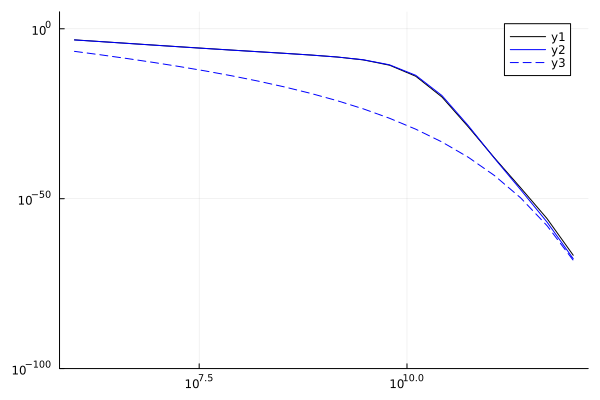

In [60]:
plot(M_array, dn_dM, xscale=:log10, yscale=:log10, color=:black)
plot!(M_array, dn_dM_with_pmf(M_array, 30.0, 1, -2.5), xscale=:log10, yscale=:log10, color=:blue)
plot!(M_array, cj.dn_dM.(M_array, 30.0, cj.SharpK), linestyle=:dash, color=:blue)
plot!(ylims = [1e-100, 1e+5])

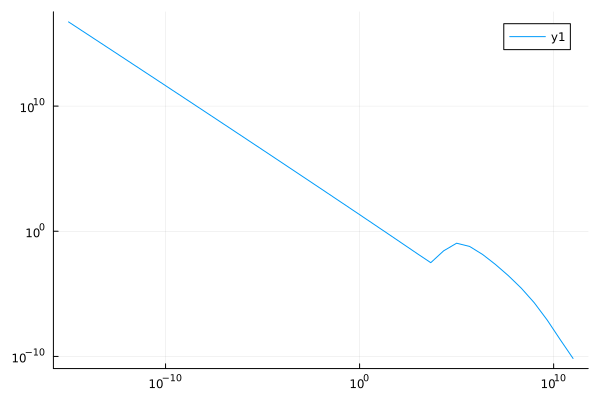

In [136]:
M_array = 10.0.^range(-15, 11, 40)
plot(M_array, abs.(dσ2_M_with_pmf.(M_array, 0.0, 1, -2.5)), xscale=:log10, yscale=:log10)